In [2]:
import segmentation_utils as su
import matplotlib.pyplot as plt
import cv2 
import numpy as np

In [2]:
img_path = r"D:\autograde\IMG_1581_iter_0.jpg"

27

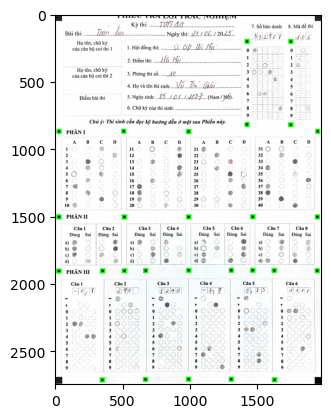

In [3]:
warped = su.four_point_transform(img_path)
su.drawSquareContours(warped)

In [8]:
centroids = su.findSquareContourCentroid(warped) #centroid of 27 square contours
centroids = list(reversed(centroids))
sorted_points = su.sort_points_grid(centroids)
sorted_points

[(1421, 202),
 (1745, 203),
 (1421, 819),
 (1744, 821),
 (30, 870),
 (509, 869),
 (988, 871),
 (1944, 870),
 (28, 1505),
 (512, 1505),
 (988, 1504),
 (1463, 1503),
 (1942, 1505),
 (28, 1906),
 (352, 1905),
 (513, 1904),
 (671, 1903),
 (989, 1901),
 (1304, 1900),
 (1463, 1901),
 (1622, 1901),
 (1941, 1903),
 (349, 2713),
 (670, 2710),
 (987, 2708),
 (1304, 2709),
 (1624, 2712)]

In [14]:
def segmentation_first_small_part(warped):
    centroids = su.findSquareContourCentroid(warped)
    sorted_points = su.sort_points_grid(centroids, row_threshold=15)

    image = warped.copy()

    pivot1 = sorted_points[0]
    #pivot2 = sorted_points[1]
    pivot3 = sorted_points[2]
    pivot4 = sorted_points[3]

    #width, height, _ = image.shape
    height, width, _ = image.shape

    pivot1 = (pivot1[0], 0)
    pivot4 = (width, pivot4[1])

    first_small_part = image[pivot1[1]:pivot3[1], pivot3[0]:pivot4[0]]

    return first_small_part

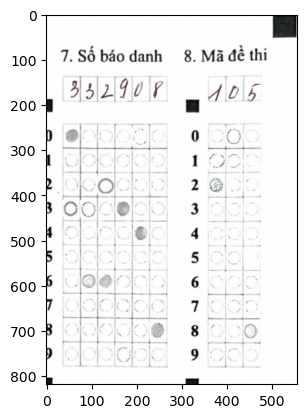

In [15]:
first_small_part = segmentation_first_small_part(warped)

plt.imshow(first_small_part)

In [18]:
def segmentation_3_parts(warped):
    centroids = su.findSquareContourCentroid(warped)
    sorted_points = su.sort_points_grid(centroids, row_threshold=15)

    image = warped.copy()

    pivot1 = sorted_points[4] #5th
    pivot2 = sorted_points[7] #8th
    pivot3 = sorted_points[8] #9th
    pivot4 = sorted_points[12] #13th

    pivot5 = sorted_points[13] #14th
    pivot6 = sorted_points[21] #22th
    pivot7 = sorted_points[22] #23th
    pivot8 = sorted_points[26] #27th 

    height, width, _ = image.shape 

    segments = [
        (pivot1[1], pivot4[1], pivot1[0], pivot4[0]), #part I
        (pivot3[1], pivot6[1], pivot3[0], pivot6[0]), #part II
        (pivot5[1], pivot8[1], pivot5[0], pivot8[0]), #part III
    ]

    cropped_images = []
    for idx, (y1, y2, x1, x2) in enumerate(segments):
        cropped = image[y1:y2, x1:x2]
        #resize_image = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
        cropped_images.append(cropped)
    
    return cropped_images

In [19]:
cropped_images = segmentation_3_parts(warped)

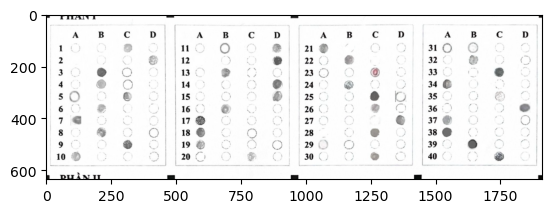

In [22]:
plt.imshow(cropped_images[0])

In [4]:
cropped_images = su.segment_type_ii(warped)

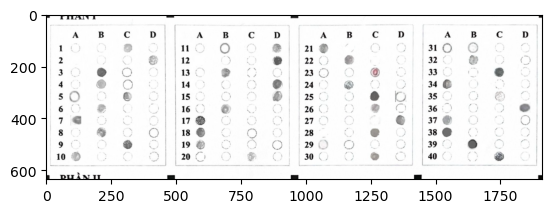

In [5]:
plt.imshow(cropped_images[0])

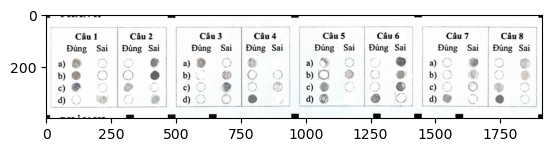

In [6]:
plt.imshow(cropped_images[1])

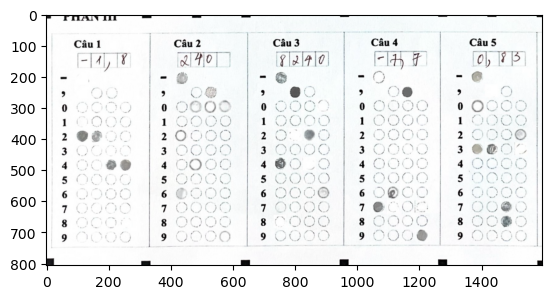

In [7]:
plt.imshow(cropped_images[2])

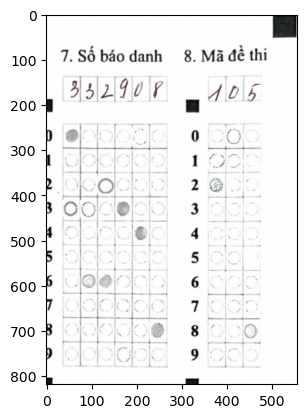

In [8]:
plt.imshow(cropped_images[3])

In [16]:
def enhance_image(img):
    #Apply Gaussian blur to reduce noise 

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    denoised = cv2.GaussianBlur(img, (3,3), 0)

    #Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        denoised,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV,
        11,
        2
    )

    #Morphological operations to clean up the image
    kernel = np.ones((2,2), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Edge enhancement
    gradient = cv2.morphologyEx(opening, cv2.MORPH_GRADIENT, kernel)
    
    # Combine enhanced edges with original image
    enhanced = cv2.addWeighted(opening, 0.7, gradient, 0.3, 0)
    
    # Optional: Apply histogram equalization for better contrast
    enhanced = cv2.equalizeHist(enhanced)
    
    return enhanced

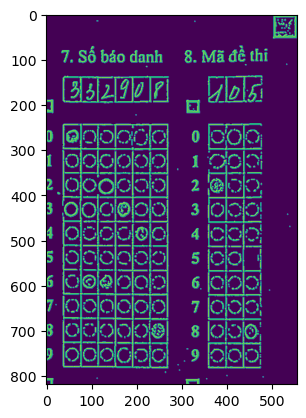

In [17]:
enhanced = enhance_image(cropped_images[3])
plt.imshow(enhanced)

In [18]:
def detect_circles(enhanced_image):
    """
    Detect circles in the enhanced image using Hough Circle Transform
    """
    circles = cv2.HoughCircles(
        enhanced_image,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,
        param2=30,
        minRadius=5,
        maxRadius=20
    )
    
    return circles

def process_bubble_sheet(img):
    # Enhance image
    enhanced = enhance_image(img)
    
    # Detect circles
    circles = detect_circles(enhanced)
    
    # Draw detected circles on original image for visualization
    result = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            # Circle center
            cv2.circle(result, center, 1, (0, 100, 100), 3)
            # Circle outline
            radius = i[2]
            cv2.circle(result, center, radius, (255, 0, 255), 2)
    
    return enhanced, result

In [19]:
enhanced, result = process_bubble_sheet(cropped_images[3])

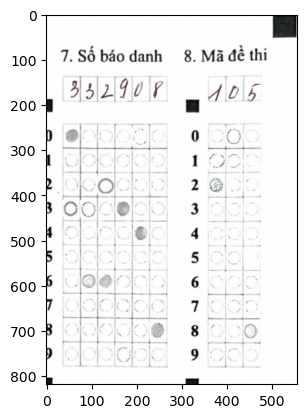

In [22]:
plt.imshow(cropped_images[3])

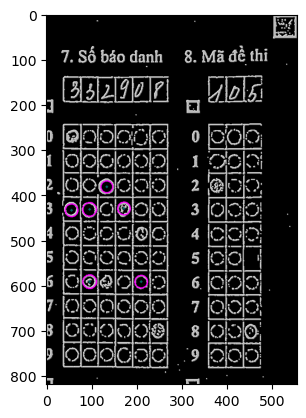

In [21]:
plt.imshow(result)

In [24]:
def check_color_format(image):
    # Check the shape of the image
    if len(image.shape) != 3:
        return "Not a color image (grayscale or binary)"
    
    # Split the channels
    channel1, channel2, channel3 = cv2.split(image)
    
    # Compare the channels to see which has more red/blue content
    red_content = np.mean(channel1) if image.shape[2] == 3 else 0
    blue_content = np.mean(channel3) if image.shape[2] == 3 else 0
    
    # Look for areas that are distinctly red or blue in the image
    if red_content > blue_content:
        return "Likely RGB format"
    elif blue_content > red_content:
        return "Likely BGR format"
    else:
        return "Unable to determine definitively"

In [25]:
check_color_format(cropped_images[3])

'Likely RGB format'

In [27]:
def enhance_and_detect_contours(img):
    # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
    # Apply Gaussian blur to reduce noise
    denoised = cv2.GaussianBlur(img, (5,5), 0)
    
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        denoised,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11,
        2
    )
    
    # Find contours
    contours, hierarchy = cv2.findContours(
        thresh,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Create output image for visualization
    result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # Filter and process contours
    filtered_contours = []
    for contour in contours:
        # Calculate contour area and perimeter
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Filter based on area and circularity
        if area > 50 and area < 500:  # Adjust these thresholds based on your image
            # Calculate circularity
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            
            # Circles have circularity close to 1
            if 0.7 < circularity < 1.3:  # Adjust tolerance as needed
                filtered_contours.append(contour)
                
                # Fit circle to contour
                center, radius = cv2.minEnclosingCircle(contour)
                center = tuple(map(int, center))
                radius = int(radius)
                
                # Draw the contour and fitted circle
                cv2.drawContours(result, [contour], -1, (0, 255, 0), 2)
                cv2.circle(result, center, radius, (0, 0, 255), 2)
                
                # Calculate filled status
                mask = np.zeros(thresh.shape, np.uint8)
                cv2.drawContours(mask, [contour], -1, 255, -1)
                mean_intensity = cv2.mean(img, mask=mask)[0]
                
                # Add text indicating if bubble is filled
                if mean_intensity < 200:  # Adjust threshold as needed
                    cv2.putText(result, 'Filled', 
                              (center[0]-20, center[1]-20),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    
    return {
        'original': img,
        'threshold': thresh,
        'result': result,
        'num_contours': len(filtered_contours),
        'filtered_contours': filtered_contours
    }

In [28]:
dic = enhance_and_detect_contours(cropped_images[3])

In [29]:
dic['num_contours']

18

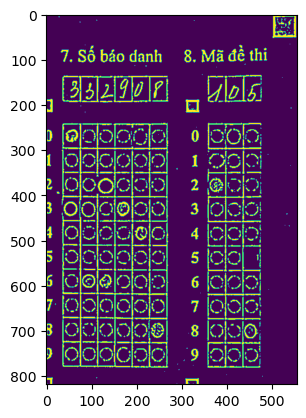

In [31]:
plt.imshow(dic['threshold'])

In [10]:
def detect_circle(img_path):
    image = cv2.imread(img_path)
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #detect circles in the image
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2, 2,3)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")

        for (x, y, r) in circles:
            #draw the circle in the output image, then draw a rectangle 
            #corresponding to the center
            #cv2.circle(output, (x,y), r, (0, 255, 0), 4)
            cv2.rectangle(output, (x-5, y-5), (x+5, y+5), (0, 128, 255), -1)

    return output 




In [3]:
cv2.HOUGH_GRADIENT

3

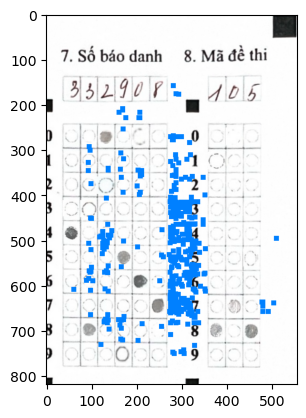

In [11]:
output = detect_circle(r"D:\autograde\zip.zip\segment_type2_part1\IMG_1581_iter_1.jpg")
plt.imshow(output)

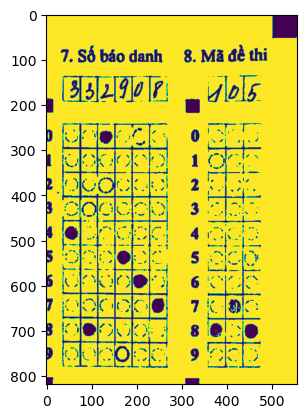

In [14]:
image = cv2.imread(r"D:\autograde\zip.zip\segment_type2_part1\IMG_1581_iter_1.jpg")
img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(img_gray, 230, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)